## 练习

1. 调整和分析超参数对运行时间、困惑度和输出顺序的影响。
1. 如何更改模型以生成适当的单词，而不是字符序列？
1. 在给定隐藏层维度的情况下，比较门控循环单元、长短期记忆网络和常规循环神经网络的计算成本。要特别注意训练和推断成本。
1. 既然候选记忆元通过使用$\tanh$函数来确保值范围在$(-1,1)$之间，那么为什么隐状态需要再次使用$\tanh$函数来确保输出值范围在$(-1,1)$之间呢？
1. 实现一个能够基于时间序列进行预测而不是基于字符序列进行预测的长短期记忆网络模型。


perplexity 18.4, 11756.1 tokens/sec on cuda:0
time traveller                                                  
traveller                                                  
Learning Rate: 0.01, Hidden Size: 512, Training Time: 377.59 seconds


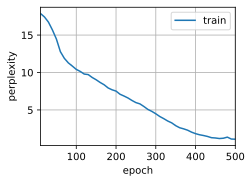

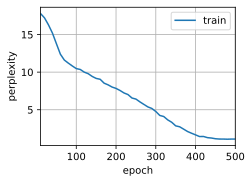

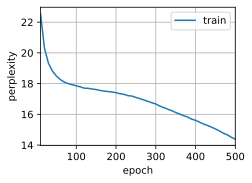

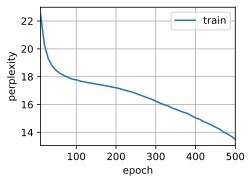

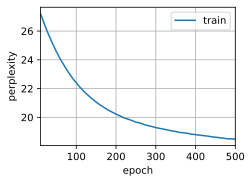

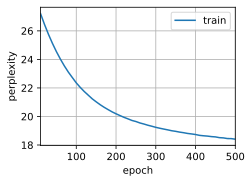

In [6]:
## 练习1
import torch
from torch import nn
from d2l import torch as d2l
import time

# 加载数据
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

# LSTM 参数初始化
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

# 初始化LSTM状态
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

# LSTM 模型
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

# 设置超参数
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1

# 不同的超参数组合
learning_rates = [1, 0.1, 0.01]
hidden_sizes = [256, 512]

for lr in learning_rates:
    for num_hiddens in hidden_sizes:
        # 初始化模型参数
        params = get_lstm_params(vocab_size, num_hiddens, device)
        model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                                    init_lstm_state, lstm)

        # 记录训练时间
        start_time = time.time()

        # 训练模型
        d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

        # 计算训练时间
        end_time = time.time()
        print(f"Learning Rate: {lr}, Hidden Size: {num_hiddens}, "
              f"Training Time: {end_time - start_time:.2f} seconds")

In [8]:
## 练习2
from collections import Counter
import re

# 修改数据加载函数以按单词切分
def load_data_time_machine(batch_size, num_steps, use_random_iter=False):
    """返回时光机器数据集的迭代器和词汇表"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    text = ' '.join([re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines])
    words = text.split()
    counter = Counter(words)
    counter = dict(filter(lambda x: x[1] >= 5, counter.items()))  # 只保留至少出现5次的单词
    vocab = d2l.Vocab(counter)
    corpus = [vocab[word] for word in words if word in vocab]
    if use_random_iter:
        data_iter = d2l.RandomSeqDataLoader(corpus, batch_size, num_steps)
    else:
        data_iter = d2l.SeqDataLoader(corpus, batch_size, num_steps)
    return data_iter, vocab

# 重新加载数据
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

# 设置超参数
vocab_size = len(vocab)  
num_hiddens, device = 256, d2l.try_gpu()
num_epochs, lr = 500, 1

# 不同的超参数组合
learning_rates = [1, 0.1, 0.01]
hidden_sizes = [256, 512]

for lr in learning_rates:
    for num_hiddens in hidden_sizes:
        # 初始化模型参数
        params = get_lstm_params(vocab_size, num_hiddens, device)
        model = d2l.RNNModelScratch(vocab_size, num_hiddens, device, get_lstm_params,
                                    init_lstm_state, lstm)

        # 记录训练时间
        start_time = time.time()

        # 训练模型
        d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

        # 计算训练时间
        end_time = time.time()
        print(f"Learning Rate: {lr}, Hidden Size: {num_hiddens}, "
              f"Training Time: {end_time - start_time:.2f} seconds")


KeyError: 0

perplexity 17.9, 15865.1 tokens/sec on cuda:0
time traveller                                                  
traveller                                                  
LSTM 训练时间: 6.17秒


NameError: name 'init_gru_state' is not defined

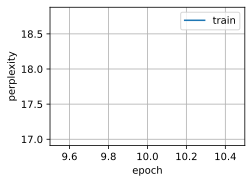

In [9]:
## 练习3
def get_gru_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐藏状态参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

def get_rnn_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh((X @ W_xh) + (H @ W_hh) + b_h)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

# 训练模型的函数
def train_and_time(model_fn, init_state_fn, params_fn, model_name):
    num_hiddens, num_epochs, lr = 256, 10, 1  # 使用较短的训练周期以节省时间
    params = params_fn(vocab_size, num_hiddens, device)
    model = d2l.RNNModelScratch(vocab_size, num_hiddens, device, params_fn,
                                init_state_fn, model_fn)

    start_time = time.time()
    d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)
    end_time = time.time()

    print(f"{model_name} 训练时间: {end_time - start_time:.2f}秒")

# 加载数据
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

# 比较不同模型
train_and_time(lstm, init_lstm_state, get_lstm_params, "LSTM")
train_and_time(gru, init_gru_state, get_gru_params, "GRU")
train_and_time(rnn, init_rnn_state, get_rnn_params, "RNN")

## 练习4
在LSTM中，隐状态\(H_t\)是通过以下公式计算的：

\[ H_t = O_t * \tanh(C_t) \]

其中，\(O_t\)是输出门的输出，它决定了记忆单元\(C_t\)的哪些部分将被输出到隐状态\(H_t\)。而\(\tanh(C_t)\)则是对记忆单元\(C_t\)的内容进行激活和缩放。

关键点在于，即使候选记忆元\(\tilde{C}_t\)的值范围被tanh函数限制在\((-1, 1)\)之间，记忆单元\(C_t\)本身是通过以下公式更新的：

\[ C_t = F_t * C_{t-1} + I_t * \tilde{C}_t \]

这里，\(F_t\)是遗忘门的输出，\(I_t\)是输入门的输出。由于这个更新过程涉及到之前记忆单元\(C_{t-1}\)的线性组合，所以新的记忆单元\(C_t\)的值可能会超出\((-1, 1)\)的范围。因此，我们需要在计算隐状态\(H_t\)之前，再次使用tanh函数来确保\(H_t\)的值位于\((-1, 1)\)范围内。

这样做有几个好处：

1. **规范化**：确保隐状态的值保持在一个规范的范围内，有助于网络的稳定性和性能。

2. **非线性**：tanh提供了必要的非线性特性，有助于模型学习复杂的数据模式。

3. **梯度传播**：在深度学习中，非线性激活函数（如tanh或ReLU）是必要的，因为它们帮助缓解梯度消失或梯度爆炸的问题，这在训练深度网络时非常重要。

In [ ]:
## 练习5
# 合成一个时间序列数据
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

def synthetic_time_series_data(T=1000):
    time = np.arange(0, T)
    x = np.sin(0.01 * time) + np.random.normal(0, 0.2, T)
    return x

# 创建数据集
T = 1000
time_series_data = synthetic_time_series_data(T)

def create_dataset(data, look_back):
    features, labels = [], []
    for i in range(len(data) - look_back):
        features.append(data[i:i + look_back])
        labels.append(data[i + look_back])
    return np.array(features), np.array(labels)

look_back = 5  # 使用过去5个时间点的数据来预测下一个时间点
features, labels = create_dataset(time_series_data, look_back)

# 转换为PyTorch的张量
features = torch.Tensor(features).unsqueeze(-1)  # 添加最后一个维度
labels = torch.Tensor(labels)

# 创建数据加载器
batch_size = 16
train_data = TensorDataset(features, labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

class LSTMTimeSeriesModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMTimeSeriesModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

input_size = 1  # 我们的特征只有一个维度
hidden_size = 64
output_size = 1  # 输出也是一个值（下一个时间点的预测值）

model = LSTMTimeSeriesModel(input_size, hidden_size, output_size)

# 训练模型
def train_model(model, train_loader, num_epochs):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(-1))
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

num_epochs = 10
train_model(model, train_loader, num_epochs)